In [1]:
import numpy as np
import matplotlib.pyplot as plt
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.nn.init as nn_init
import torch.optim as optim
from torch.utils.tensorboard import SummaryWriter
from torch.utils.data import Dataset, DataLoader
from torch.optim.lr_scheduler import StepLR
from torchvision.datasets import MNIST

In [2]:
train_data = MNIST("data/MNIST", download=True)
test_data = MNIST("data/MNIST", train=False, download=True)

In [3]:
class MNISTDataset(Dataset):
    
    def __init__(self, dataset):
        self.data = dataset
    
    def __len__(self):
        return len(self.data)
    
    def __getitem__(self, index):
        pil_image, label = self.data[index]
        image_array = np.array(pil_image)
        image_flatten = image_array.flatten() / 255
        return image_flatten.astype(np.float32), label

In [4]:
train_dataset = MNISTDataset(train_data)
test_dataset = MNISTDataset(test_data)

In [5]:
class Encoder(nn.Module):
    
    def __init__(self, input_size):
        super().__init__()
        self.lr1 = nn.Linear(in_features=input_size, out_features=512)
        self.bn1 = nn.BatchNorm1d(512)
        
        self.lr2 = nn.Linear(in_features=512, out_features=256)
        self.bn2 = nn.BatchNorm1d(256)
        
        self.lr3 = nn.Linear(in_features=256, out_features=128, bias=False)
        
    def forward(self, x):
        x = F.relu(self.bn1(self.lr1(x)))
        x = F.relu(self.bn2(self.lr2(x)))
        return self.lr3(x)

In [6]:
class Decoder(nn.Module):
    
    def __init__(self, out_size):
        super().__init__()
        self.lr1 = nn.Linear(in_features=128, out_features=256)
        self.bn1 = nn.BatchNorm1d(256)
        
        self.lr2 = nn.Linear(in_features=256, out_features=512)
        self.bn2 = nn.BatchNorm1d(512)
        
        self.lr3 = nn.Linear(in_features=512, out_features=out_size, bias=False)
        self.label_emb = nn.Embedding(10, 128)
        
    def forward(self, x, label):
        label_emb = self.label_emb(label)
        x = F.relu(self.bn1(self.lr1(x + label_emb)))
        x = F.relu(self.bn2(self.lr2(x)))
        return self.lr3(x)

In [7]:
class AutoEncoder(nn.Module):
    
    def __init__(self, vector_size):
        super().__init__()
        self.encoder = Encoder(vector_size)
        self.decoder = Decoder(vector_size)
        
    def forward(self, x, label):
        x = self.encoder(x)
        x = self.decoder(x, label)
        return x

In [8]:
N_INPUT = np.array(train_data[0][0]).size
BATCH_SIZE = 64
EPOCH = 20

In [9]:
model = AutoEncoder(N_INPUT)

In [10]:
train_loader = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=BATCH_SIZE)

In [11]:
torch.manual_seed(42)

for name, parameter in model.named_parameters():
    if "weight" in name and "lr" in name:
        nn_init.xavier_normal_(parameter)

In [12]:
optimizer = optim.SGD(model.parameters(), lr=1e-1, weight_decay=1e-5)
scheduler = StepLR(optimizer, step_size=5000, gamma=0.5)

In [13]:
criteria = nn.MSELoss()

In [14]:
model.cuda();

In [15]:
writer = SummaryWriter(log_dir="logs/mnist_generation/")

In [16]:
%load_ext tensorboard

In [17]:
%tensorboard --logdir logs/mnist_generation

In [18]:
for epoch in range(EPOCH):
    model.train()
    for i, (x, y) in enumerate(train_loader):
        x = x.cuda()
        y = y.cuda()
        optimizer.zero_grad()
        out = model(x, y)
        loss = criteria(out, x)
        loss.backward()
        optimizer.step()
        if (i + 1) % 400 == 0:
            global_iteration = epoch * len(train_loader) + i
            writer.add_scalar("train/loss", loss.item(), global_step=global_iteration)
        scheduler.step()

In [19]:
decoder = model.decoder

In [20]:
decoder.eval()

Decoder(
  (lr1): Linear(in_features=128, out_features=256, bias=True)
  (bn1): BatchNorm1d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (lr2): Linear(in_features=256, out_features=512, bias=True)
  (bn2): BatchNorm1d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (lr3): Linear(in_features=512, out_features=784, bias=False)
  (label_emb): Embedding(10, 128)
)

In [47]:
z = torch.normal(0, 5, (128,)).unsqueeze(0).cuda()

In [ ]:
generated_image = decoder(z, torch.LongTensor([0]).cuda())

In [43]:
generated_image = np.clip(generated_image.detach().cpu().numpy() * 255, 0, 255).reshape(28, 28).astype(int)

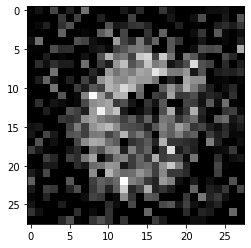

In [44]:
plt.imshow(generated_image, cmap="gray")